<a href="https://colab.research.google.com/github/brdeleon/flagging_loans_shapley_values/blob/main/flagging_loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flagging Loans

## Imports

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 7.0 MB/s eta 0:00:00


In [ ]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.5 MB/s eta 0:00:00


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.0 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import joblib as jb
from joblib import dump, load

import os
import shap
import math
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import kaleido
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, RFECV

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, brier_score_loss, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, CondensedNearestNeighbour 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as ltb
from lightgbm import LGBMClassifier
import catboost as ctb
from catboost import CatBoostClassifier

seed = np.random.seed(42)

## Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/loan_data/loan_dataset.csv')

In [ ]:
# previewing first 5 rows and last 5 rows of the dataset
df.head().append(df.tail())

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,0.0,0.0,0.0,0,3.0,region_6,6,...,0,10,0,0,0,10.0,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,...,0,6,0,0,0,5.0,NaN,20.0,False,0
2,779736,2016-10-30,2015-12-21,0.0,0.0,0.0,0,2.0,region_1,6,...,0,0,5,0,0,5.0,NaN,19.0,False,0
3,556376,2016-06-29,2015-06-30,0.0,0.0,0.0,0,1.0,region_6,14,...,0,4,0,0,0,6.0,NaN,21.0,False,0
4,266968,2015-12-01,2015-08-03,0.0,0.0,0.0,0,0.0,region_5,22,...,3,0,0,0,0,3.0,NaN,33.0,False,0
4126,533637,2016-06-11,2016-05-17,0.0,0.0,0.0,0,0.0,region_5,7,...,0,1,0,0,0,0.0,NaN,26.0,False,0
4127,596156,2016-08-06,2016-03-11,0.0,0.0,0.0,0,1.0,region_2,12,...,0,4,0,0,0,3.0,NaN,38.0,False,1
4128,645359,2016-09-05,2016-04-30,0.0,0.0,0.0,0,1.0,region_2,12,...,0,4,0,0,0,4.0,NaN,21.0,False,0
4129,730681,2016-10-14,2016-05-20,0.0,0.0,0.0,0,0.0,region_6,7,...,0,4,0,0,0,4.0,NaN,35.0,False,0
4130,521420,2016-06-02,2015-12-08,2.0,2.0,0.0,2016-02-13,0.0,region_4,12,...,0,6,0,0,0,5.0,NaN,25.0,False,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loanKey              4157 non-null   int64  
 1   rep_loan_date        4157 non-null   object 
 2   first_loan           4157 non-null   object 
 3   dpd_5_cnt            675 non-null    float64
 4   dpd_15_cnt           675 non-null    float64
 5   dpd_30_cnt           675 non-null    float64
 6   first_overdue_date   675 non-null    object 
 7   close_loans_cnt      4142 non-null   float64
 8   federal_district_nm  4146 non-null   object 
 9   TraderKey            4157 non-null   int64  
 10  payment_type_0       4157 non-null   int64  
 11  payment_type_1       4157 non-null   int64  
 12  payment_type_2       4157 non-null   int64  
 13  payment_type_3       4157 non-null   int64  
 14  payment_type_4       4157 non-null   int64  
 15  payment_type_5       4157 non-null   i

### Null Values

In [ ]:
# df.isnull().sum()
# Check the initial null value counts
initial_null_counts = df.isnull().sum()
print("Initial Null Value Counts:\n", initial_null_counts)

loanKey                   0
rep_loan_date             0
first_loan                0
dpd_5_cnt              3482
dpd_15_cnt             3482
dpd_30_cnt             3482
first_overdue_date     3482
close_loans_cnt          15
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt       248
score_1                 650
score_2                3918
age                       0
gender                    0
bad_flag                  0
dtype: int64

In [ ]:
# calculating nulls
nulls = df.isnull().sum()

In [ ]:
# calculating null percentage of columns with nulls
null_percent = nulls[nulls>0] / len(df)
null_percent.sort_values(ascending=False).to_frame('% Null').style

,% Null
score_2,0.942507
dpd_5_cnt,0.837623
dpd_15_cnt,0.837623
dpd_30_cnt,0.837623
first_overdue_date,0.837623
score_1,0.156363
past_billings_cnt,0.059658
close_loans_cnt,0.003608
federal_district_nm,0.002646


In [ ]:
# extracting columns with excesssive nulls set at 10%
null_columns = null_percent[null_percent>.90].index.tolist()
null_columns

['score_2']

In [ ]:
df['score_2'].value_counts(dropna=False)

NaN           3918
563.089780      31
572.357000      25
518.895382      25
576.875277      15
546.439438      14
554.816921      11
564.084141      11
556.757944       8
529.213889       8
535.545724       8
561.276222       7
538.166579       5
550.957715       5
539.335885       5
548.485086       4
533.918380       4
603.311653       4
559.335199       4
583.194320       4
567.608057       3
544.812944       3
598.793375       2
568.602419       2
570.630791       2
553.003363       2
523.736829       2
513.513456       2
572.875813       2
532.104821       2
527.586544       2
577.394091       1
485.874267       1
505.145464       1
506.374324       1
553.980449       1
531.063026       1
513.418322       1
575.149069       1
517.268037       1
589.526155       1
515.463970       1
556.505040       1
521.786315       1
542.684857       1
515.641544       1
538.436657       1
549.331222       1
Name: score_2, dtype: int64

In [ ]:
# dropping column list and checking shape
df = df.drop(columns = null_columns)
print(df.shape)

(4157, 21)


There are 4 remaining columns with high null values, they all seem to address similar data. We will drop the first_overdue_date data as it is represented in some capacity with dpd_5_cnt. [as the object column likely represents a date or timestamp indicating the first occurrence of delinquency, which is a different type of information compared to the count of delinquency days. Therefore, it is unlikely that there would be direct multicollinearity between the float64 columns and the object column.]
However, it's important to note that multicollinearity can also arise indirectly in a model when multiple correlated predictors are used together, even if they are of different data types. For example, if the date or timestamp information in the object column is used to derive additional features that are highly correlated with the float64 columns, multicollinearity may still be an issue. Therefore, it is important to carefully analyze the data, conduct exploratory data analysis (EDA), and assess for multicollinearity using appropriate techniques, as mentioned in the previous response, to determine if multicollinearity is indeed present and take appropriate steps to address it if needed.

In [ ]:
 df['first_overdue_date'].value_counts(dropna=False)

NaN           3482
2016-01-15      63
2016-04-30      25
2016-05-30      21
2016-01-30      20
              ... 
2016-11-13       1
2016-05-19       1
2016-08-30       1
2015-06-10       1
2016-07-18       1
Name: first_overdue_date, Length: 79, dtype: int64

In [ ]:
df['dpd_5_cnt'].value_counts(dropna=False)

NaN    3482
1.0     484
2.0     114
3.0      47
4.0      14
5.0       7
0.0       4
6.0       4
7.0       1
Name: dpd_5_cnt, dtype: int64

In [ ]:
df[['dpd_5_cnt', 'first_overdue_date']].head(20)

,dpd_5_cnt,first_overdue_date
0,NaN,NaN
1,1.0,2016-01-30
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,1.0,2015-11-06
7,1.0,2015-11-06
8,3.0,2016-01-15
9,1.0,2015-11-06


In [ ]:
 df['dpd_15_cnt'].value_counts(dropna=False)

NaN    3482
1.0     314
0.0     281
2.0      66
3.0       9
4.0       3
5.0       2
Name: dpd_15_cnt, dtype: int64

In [ ]:
 df['dpd_30_cnt'].value_counts(dropna=False)

NaN    3482
0.0     502
1.0     158
2.0      14
3.0       1
Name: dpd_30_cnt, dtype: int64

In [ ]:
# Fill nulls with 0 for specific columns
columns_to_fill_with_zero = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'first_overdue_date']
df[columns_to_fill_with_zero] = df[columns_to_fill_with_zero].fillna(0)

In [ ]:
# Checking for nulls after data edits
df.isnull().sum()

loanKey                  0
rep_loan_date            0
first_loan               0
dpd_5_cnt                0
dpd_15_cnt               0
dpd_30_cnt               0
first_overdue_date       0
close_loans_cnt         15
federal_district_nm     11
TraderKey                0
payment_type_0           0
payment_type_1           0
payment_type_2           0
payment_type_3           0
payment_type_4           0
payment_type_5           0
past_billings_cnt      248
score_1                650
age                      0
gender                   0
bad_flag                 0
dtype: int64

In [ ]:
corr_matrix = df[['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']].corr()
print(corr_matrix)


            dpd_5_cnt  dpd_15_cnt  dpd_30_cnt
dpd_5_cnt    1.000000    0.745065    0.462980
dpd_15_cnt   0.745065    1.000000    0.642321
dpd_30_cnt   0.462980    0.642321    1.000000


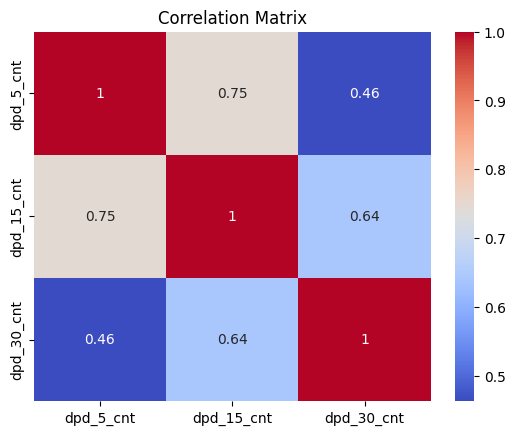

In [ ]:
corr_matrix = df[['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show();

In [ ]:
df[['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']].head(35)

,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,1.0,0.0
8,3.0,1.0,0.0
9,1.0,1.0,0.0


In [ ]:
df['dpd_5_cnt'].value_counts(dropna=False)

0.0    3486
1.0     484
2.0     114
3.0      47
4.0      14
5.0       7
6.0       4
7.0       1
Name: dpd_5_cnt, dtype: int64

In [ ]:
df['dpd_15_cnt'].value_counts(dropna=False)

0.0    3763
1.0     314
2.0      66
3.0       9
4.0       3
5.0       2
Name: dpd_15_cnt, dtype: int64

In [ ]:
df['dpd_30_cnt'].value_counts(dropna=False)

0.0    3984
1.0     158
2.0      14
3.0       1
Name: dpd_30_cnt, dtype: int64

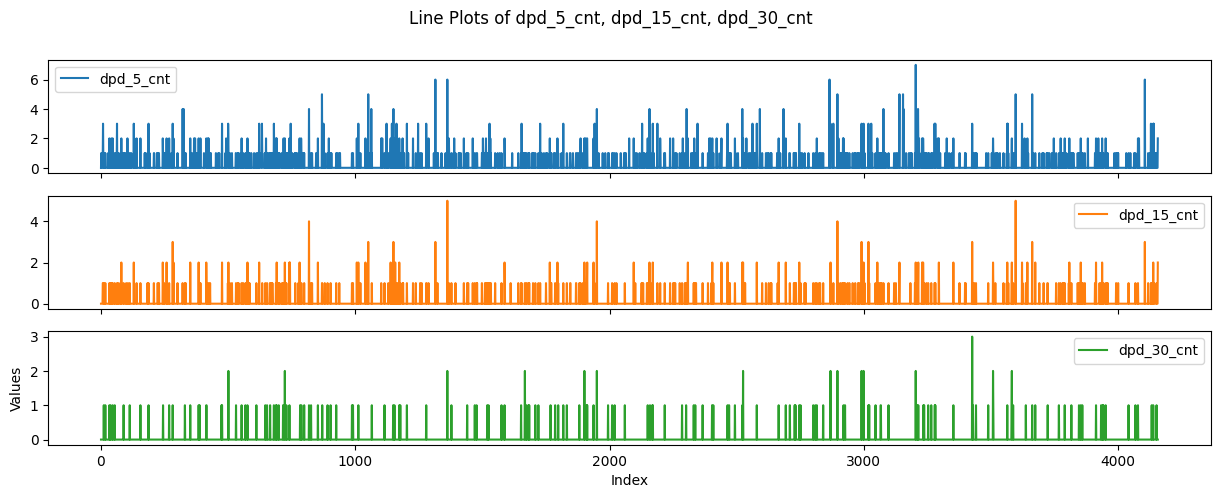

In [ ]:
import matplotlib.pyplot as plt

# Extract columns from the DataFrame
columns = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']
df[columns].plot(subplots=True, layout=(len(columns),1), figsize=(15,5))

# Set the title and labels for the plot
plt.suptitle('Line Plots of dpd_5_cnt, dpd_15_cnt, dpd_30_cnt')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()


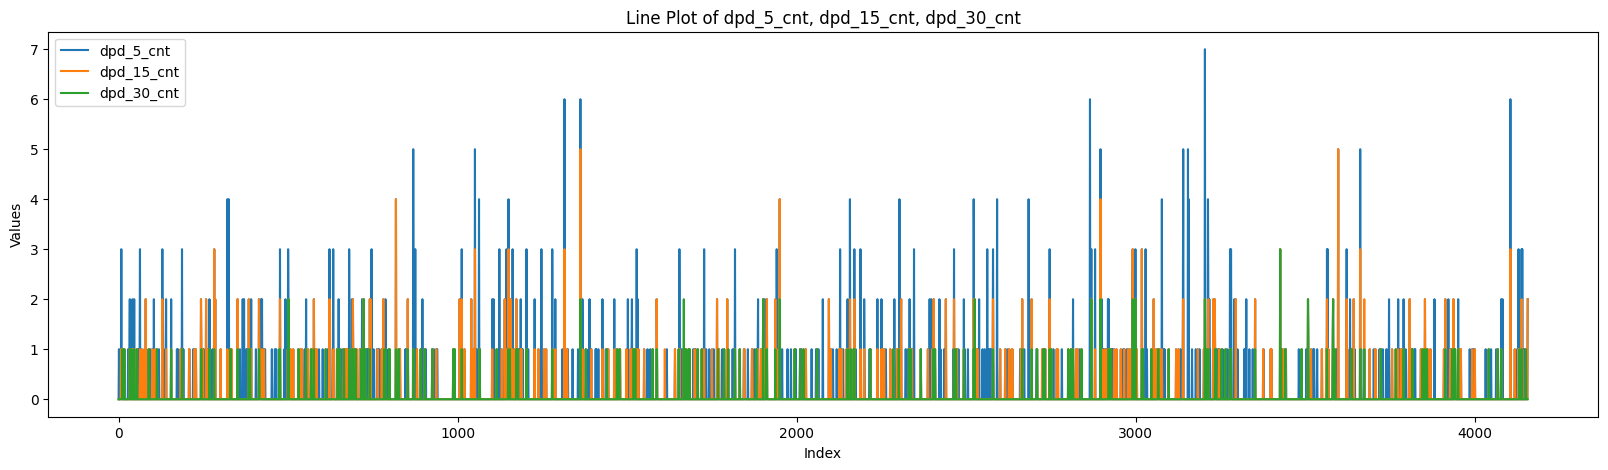

In [ ]:
# Extract columns from the DataFrame
columns = ['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']
df[columns].plot(legend=True, figsize=(20,5))

# Set the title and labels for the plot
plt.title('Line Plot of dpd_5_cnt, dpd_15_cnt, dpd_30_cnt')
plt.xlabel('Index')
plt.ylabel('Values')

# Display the plot
plt.show()


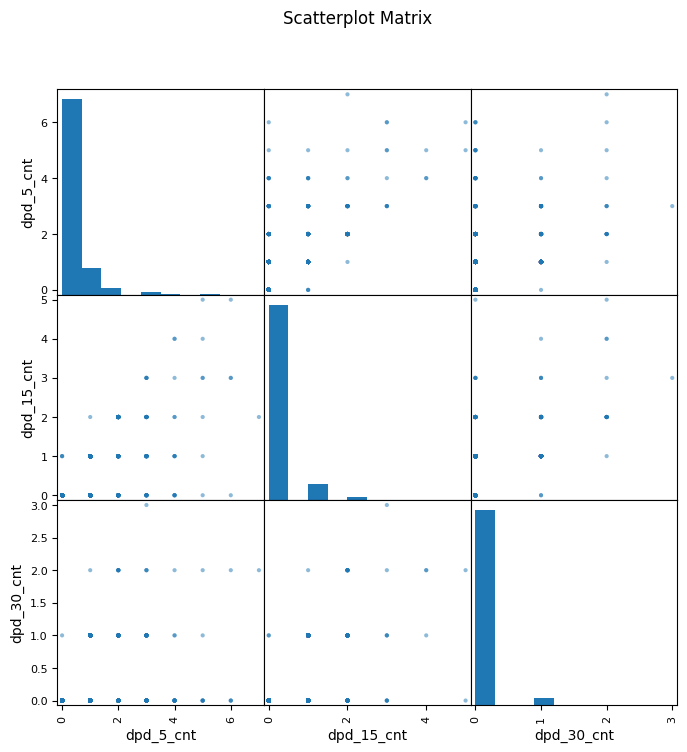

In [ ]:
import pandas.plotting as pdplt

pdplt.scatter_matrix(df[['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']], figsize=(8, 8), diagonal='hist')
plt.suptitle('Scatterplot Matrix')
plt.show()


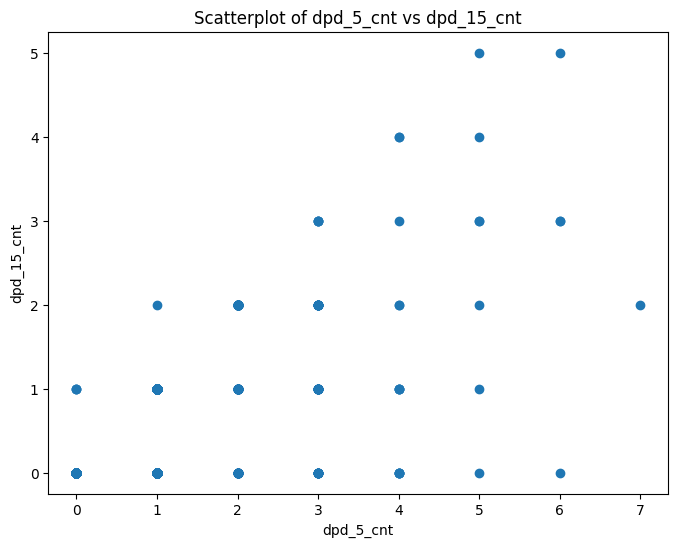

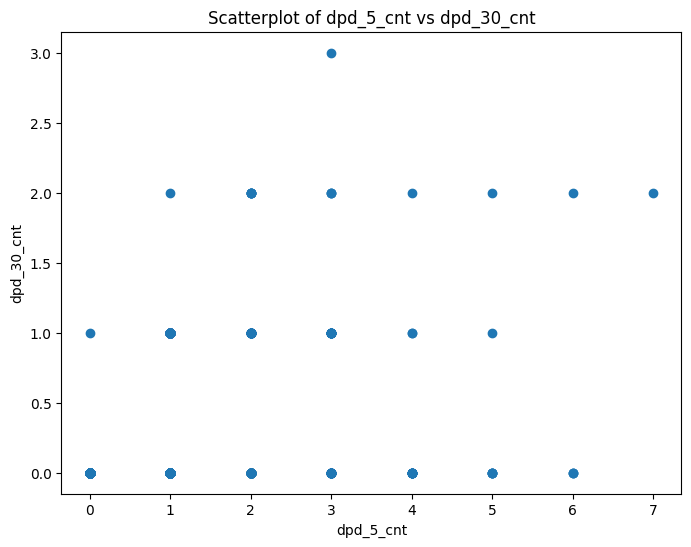

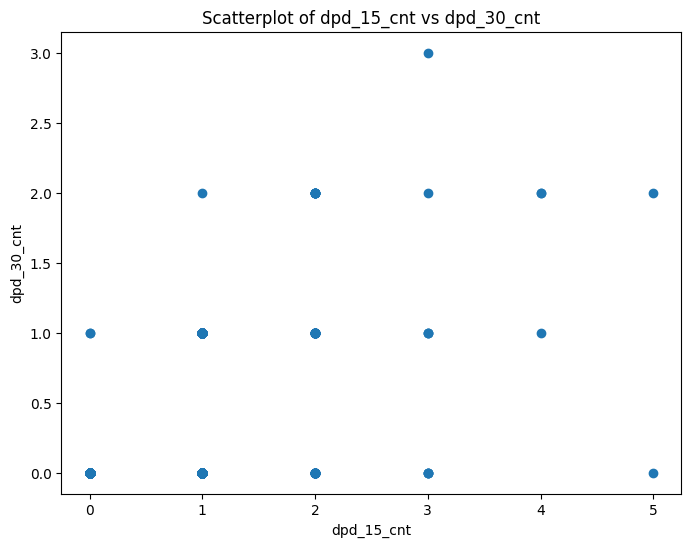

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['dpd_5_cnt'], df['dpd_15_cnt'])
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_15_cnt')
plt.title('Scatterplot of dpd_5_cnt vs dpd_15_cnt')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['dpd_5_cnt'], df['dpd_30_cnt'])
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_30_cnt')
plt.title('Scatterplot of dpd_5_cnt vs dpd_30_cnt')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['dpd_15_cnt'], df['dpd_30_cnt'])
plt.xlabel('dpd_15_cnt')
plt.ylabel('dpd_30_cnt')
plt.title('Scatterplot of dpd_15_cnt vs dpd_30_cnt')
plt.show();

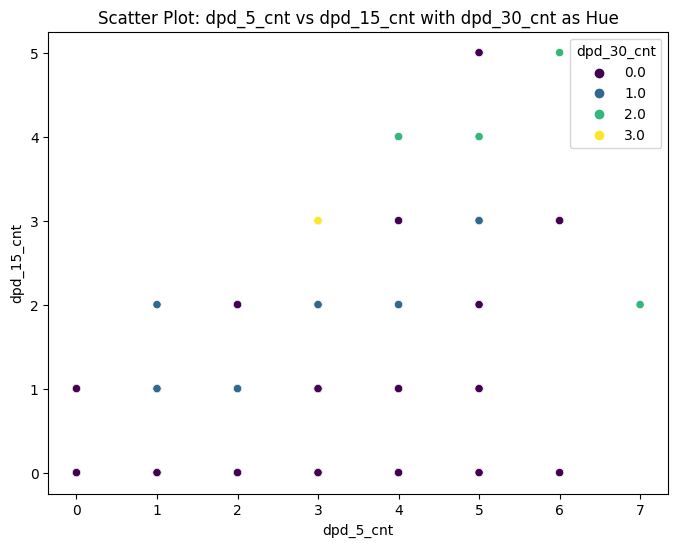

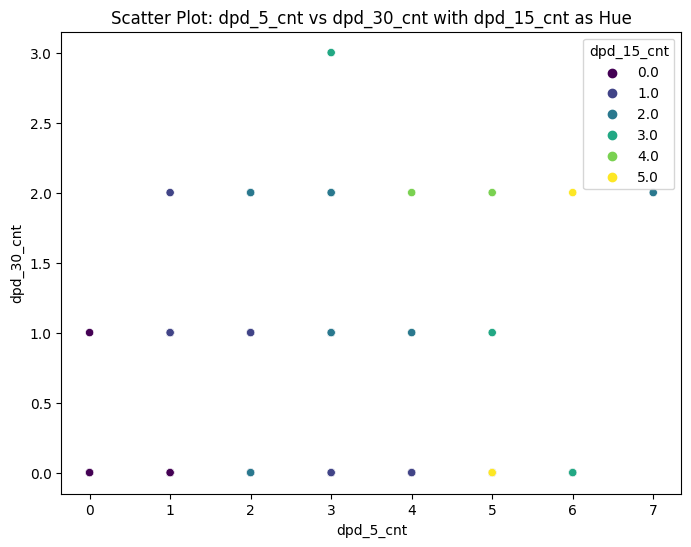

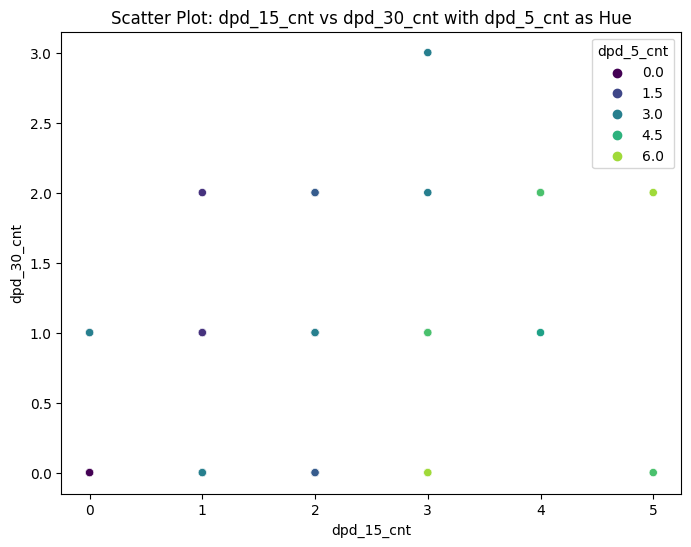

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plots
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='dpd_5_cnt', y='dpd_15_cnt', hue='dpd_30_cnt', palette='viridis')
plt.title('Scatter Plot: dpd_5_cnt vs dpd_15_cnt with dpd_30_cnt as Hue')
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_15_cnt')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='dpd_5_cnt', y='dpd_30_cnt', hue='dpd_15_cnt', palette='viridis')
plt.title('Scatter Plot: dpd_5_cnt vs dpd_30_cnt with dpd_15_cnt as Hue')
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_30_cnt')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='dpd_15_cnt', y='dpd_30_cnt', hue='dpd_5_cnt', palette='viridis')
plt.title('Scatter Plot: dpd_15_cnt vs dpd_30_cnt with dpd_5_cnt as Hue')
plt.xlabel('dpd_15_cnt')
plt.ylabel('dpd_30_cnt')
plt.show()


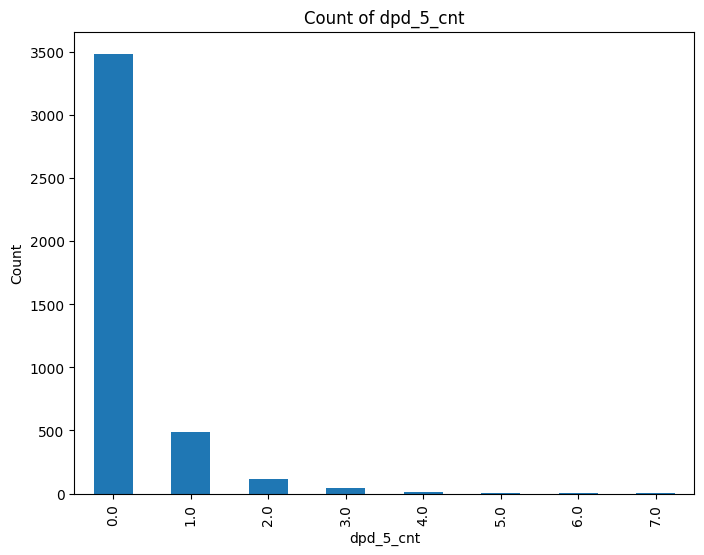

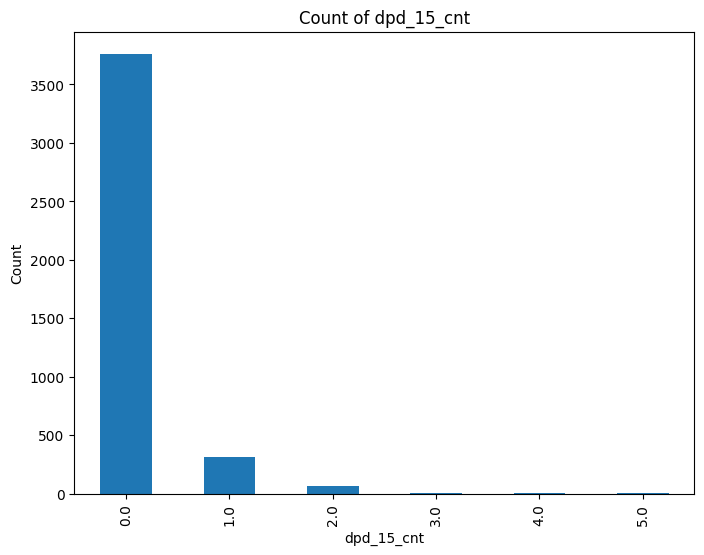

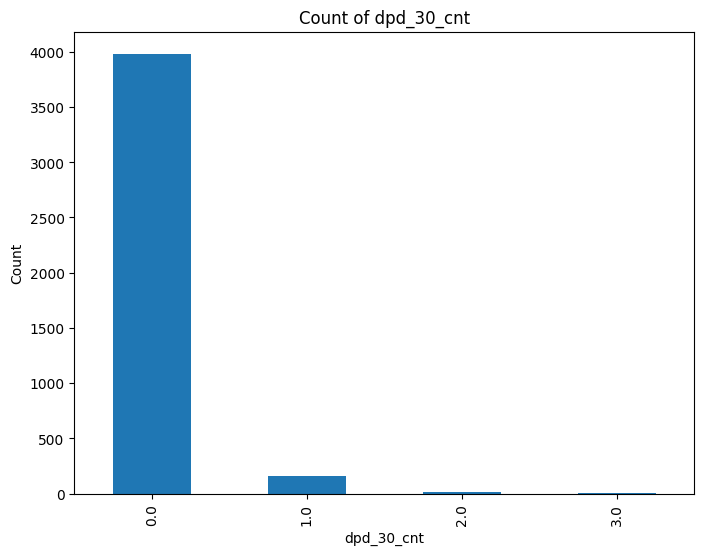

In [ ]:
# Bar chart for dpd_5_cnt
plt.figure(figsize=(8, 6))
df['dpd_5_cnt'].value_counts().sort_index().plot(kind='bar')
plt.title('Count of dpd_5_cnt')
plt.xlabel('dpd_5_cnt')
plt.ylabel('Count')
plt.show()

# Bar chart for dpd_15_cnt
plt.figure(figsize=(8, 6))
df['dpd_15_cnt'].value_counts().sort_index().plot(kind='bar')
plt.title('Count of dpd_15_cnt')
plt.xlabel('dpd_15_cnt')
plt.ylabel('Count')
plt.show()

# Bar chart for dpd_30_cnt
plt.figure(figsize=(8, 6))
df['dpd_30_cnt'].value_counts().sort_index().plot(kind='bar')
plt.title('Count of dpd_30_cnt')
plt.xlabel('dpd_30_cnt')
plt.ylabel('Count')
plt.show()


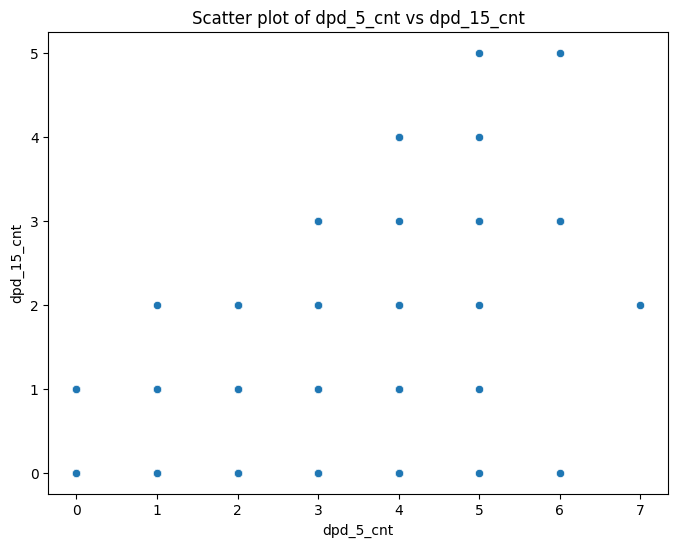

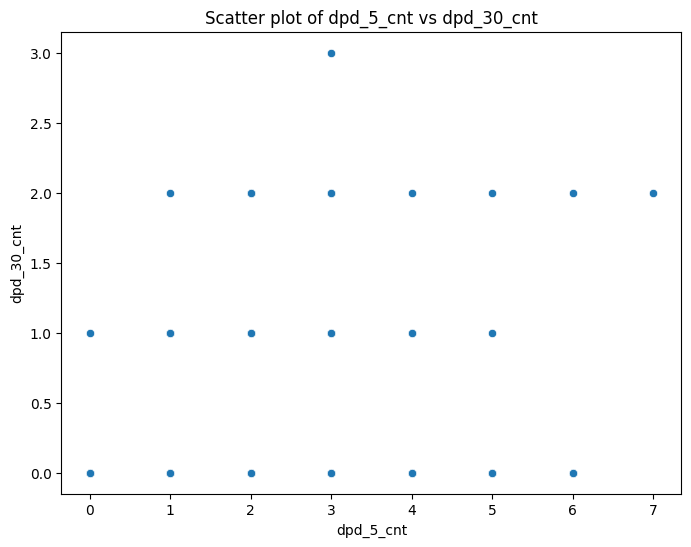

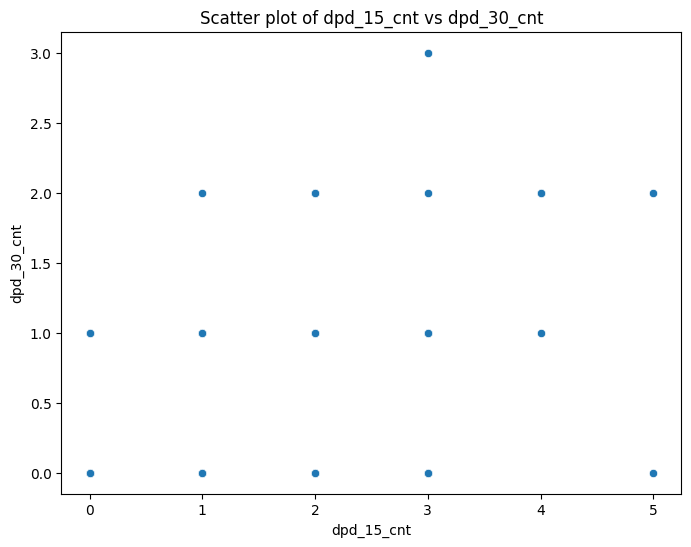

In [ ]:
# Scatter plot for dpd_5_cnt vs dpd_15_cnt
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dpd_5_cnt', y='dpd_15_cnt', data=df)
plt.title('Scatter plot of dpd_5_cnt vs dpd_15_cnt')
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_15_cnt')
plt.show()

# Scatter plot for dpd_5_cnt vs dpd_30_cnt
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dpd_5_cnt', y='dpd_30_cnt', data=df)
plt.title('Scatter plot of dpd_5_cnt vs dpd_30_cnt')
plt.xlabel('dpd_5_cnt')
plt.ylabel('dpd_30_cnt')
plt.show()

# Scatter plot for dpd_15_cnt vs dpd_30_cnt
plt.figure(figsize=(8, 6))
sns.scatterplot(x='dpd_15_cnt', y='dpd_30_cnt', data=df)
plt.title('Scatter plot of dpd_15_cnt vs dpd_30_cnt')
plt.xlabel('dpd_15_cnt')
plt.ylabel('dpd_30_cnt')
plt.show()


We will perform PCA on the three columns to preserve the important information while avoiding the multicolinearity that was present.

In [ ]:
df.isnull().sum()

loanKey                  0
rep_loan_date            0
first_loan               0
dpd_5_cnt                0
dpd_15_cnt               0
dpd_30_cnt               0
first_overdue_date       0
close_loans_cnt         15
federal_district_nm     11
TraderKey                0
payment_type_0           0
payment_type_1           0
payment_type_2           0
payment_type_3           0
payment_type_4           0
payment_type_5           0
past_billings_cnt      248
score_1                650
age                      0
gender                   0
bad_flag                 0
dtype: int64

In [ ]:
# Drop rows with nulls in 'close_loans_cnt', 'federal_district_nm' columns in one line
df.dropna(subset=['close_loans_cnt', 'federal_district_nm'], inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

In [ ]:
df['past_billings_cnt'].value_counts(dropna=False)

3.0     806
6.0     521
1.0     496
2.0     489
5.0     335
4.0     287
NaN     233
7.0     205
8.0     176
9.0     152
10.0    122
11.0     72
12.0     69
13.0     43
14.0     40
16.0     28
15.0     22
17.0     19
18.0      9
19.0      3
20.0      2
21.0      2
Name: past_billings_cnt, dtype: int64

We will fill the null values with zeros to represent that these rows are missing a value because they do not have any past bills. The assumption is that this is their first loan.

In [ ]:
df['past_billings_cnt'] = df['past_billings_cnt'].fillna(0)
df.isnull().sum()

loanKey                  0
rep_loan_date            0
first_loan               0
dpd_5_cnt                0
dpd_15_cnt               0
dpd_30_cnt               0
first_overdue_date       0
close_loans_cnt          0
federal_district_nm      0
TraderKey                0
payment_type_0           0
payment_type_1           0
payment_type_2           0
payment_type_3           0
payment_type_4           0
payment_type_5           0
past_billings_cnt        0
score_1                645
age                      0
gender                   0
bad_flag                 0
dtype: int64

df['score_1']

In [ ]:
# Find the lowest value in the 'score_1' column
lowest_value = df['score_1'].min()

# Display the lowest value
print(lowest_value)

384.22062775079314


In [ ]:

# Sort the 'score_1' column in ascending order, including any 0 and null values
sorted_df = df.sort_values('score_1', ascending=True, na_position='first')

# Select the first 5 rows from the sorted DataFrame
lowest_values = sorted_df['score_1'].head(647)

# Display the lowest 5 values
print(lowest_values)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
4128           NaN
4129           NaN
4130           NaN
978     384.220628
1257    385.181110
Name: score_1, Length: 647, dtype: float64


In [ ]:
# Select the first 5 rows from the sorted DataFrame
low_values = sorted_df[['score_1']].head(647)

# Display the lowest 5 values
print(low_values)

         score_1
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
...          ...
4128         NaN
4129         NaN
4130         NaN
978   384.220628
1257  385.181110

[647 rows x 1 columns]


In [ ]:
sorted_df[['score_1','first_loan','past_billings_cnt','age']].head(647)

,score_1,first_loan,past_billings_cnt,age
0,NaN,2015-11-13,10.0,21.0
1,NaN,2015-09-28,5.0,20.0
2,NaN,2015-12-21,5.0,19.0
3,NaN,2015-06-30,6.0,21.0
4,NaN,2015-08-03,3.0,33.0
...,...,...,...,...
4128,NaN,2016-04-30,4.0,21.0
4129,NaN,2016-05-20,4.0,35.0
4130,NaN,2015-12-08,5.0,25.0
978,384.220628,2015-08-30,0.0,21.0


In [ ]:
sorted_df['age'].value_counts()

28.0    189
27.0    177
31.0    176
30.0    167
26.0    164
32.0    161
24.0    158
29.0    154
33.0    151
35.0    145
25.0    141
34.0    139
23.0    131
36.0    125
21.0    121
39.0    111
37.0    109
38.0    102
22.0    101
41.0    101
40.0     98
20.0     89
18.0     81
43.0     79
42.0     77
44.0     66
19.0     65
46.0     59
47.0     59
45.0     57
51.0     53
48.0     52
54.0     45
53.0     43
49.0     40
56.0     39
52.0     38
55.0     36
59.0     34
58.0     33
57.0     32
50.0     32
63.0     22
60.0     22
61.0     18
62.0     16
64.0     14
65.0      6
67.0      1
70.0      1
74.0      1
Name: age, dtype: int64

We will assume that the null values are representative of having no credit score.

In [92]:
# Fill missing values in 'score_1' column with 0
df['score_1'] = df['score_1'].fillna(0)

In [93]:
# Check the final null value counts 
final_null_counts = df.isnull().sum()
print(f"Final Null Value Counts:\n{final_null_counts}")

Final Null Value Counts:
loanKey                0
rep_loan_date          0
first_loan             0
dpd_5_cnt              0
dpd_15_cnt             0
dpd_30_cnt             0
first_overdue_date     0
close_loans_cnt        0
federal_district_nm    0
TraderKey              0
payment_type_0         0
payment_type_1         0
payment_type_2         0
payment_type_3         0
payment_type_4         0
payment_type_5         0
past_billings_cnt      0
score_1                0
age                    0
gender                 0
bad_flag               0
dtype: int64


### Duplicates
We will check for duplicates and remove them. We will check the dataset shape to confirm their removal.

In [94]:
# checking for duplicates and df shape 
print(df.duplicated().sum())
df.shape

0


(4131, 21)

In [97]:
# saving final df as a new csv file.
df.to_csv('/content/drive/MyDrive/loan_data/clean_loan_df.csv',index=False)

### Correlation Check

Checking for multicolinearity amongst the features in the data.

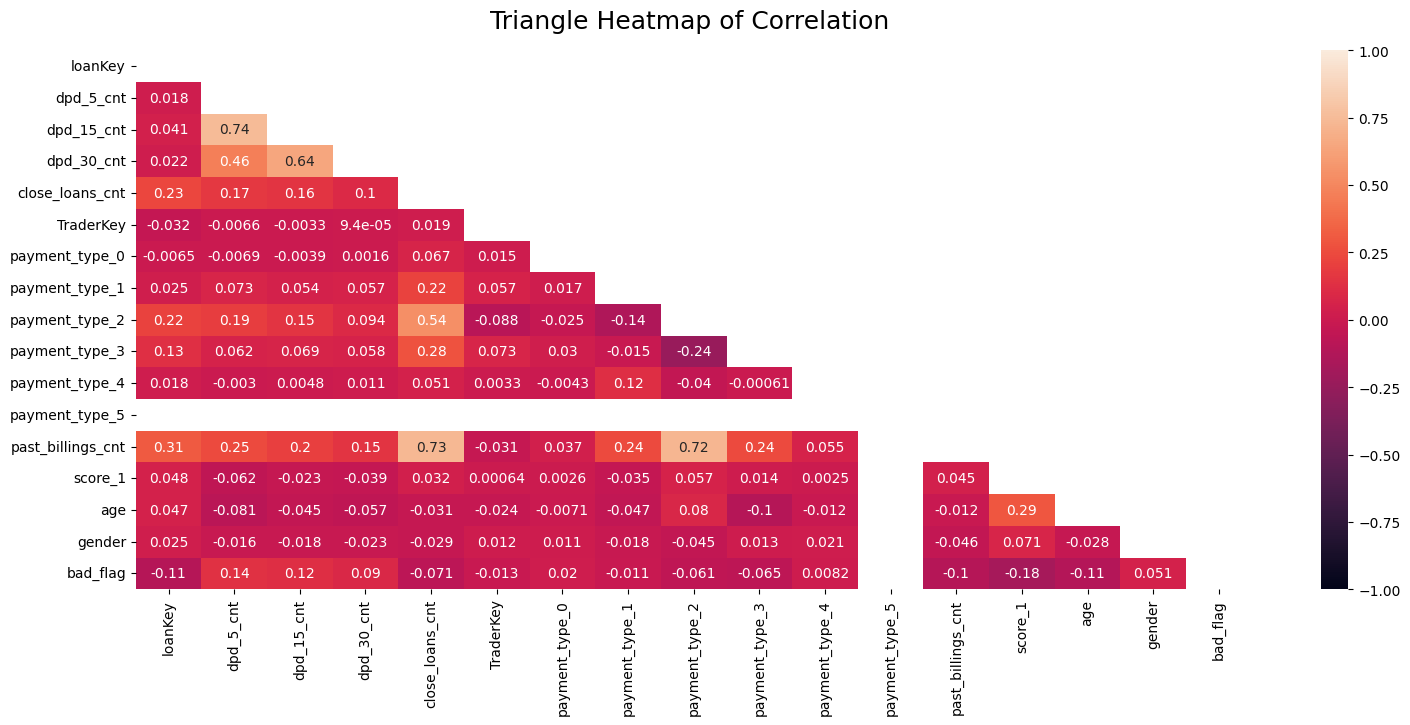

In [99]:
# setting figure size
plt.figure(figsize=(18,7))
# creating heatmap 
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, annot=True, vmin=-1, vmax=1, linecolor='black')
heatmap.set_title('Triangle Heatmap of Correlation ', fontdict={'fontsize':18}, pad=16);

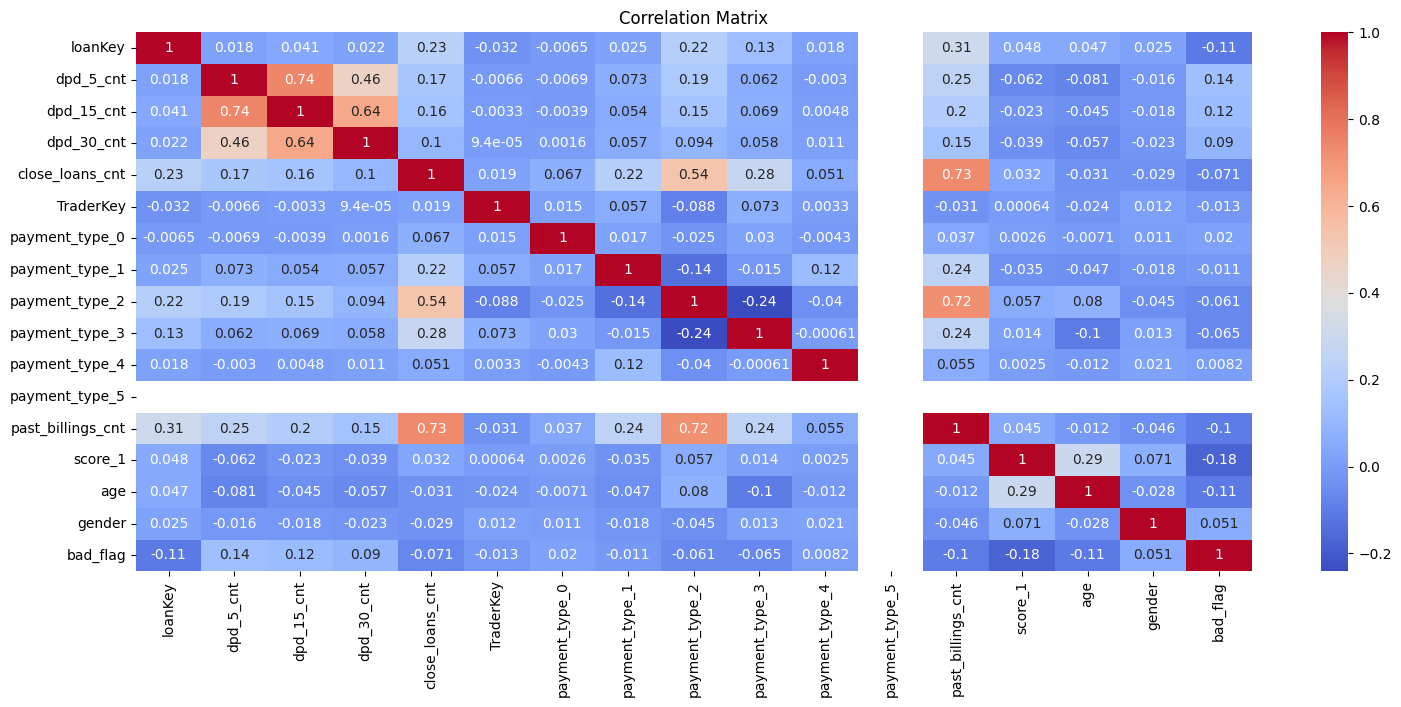

In [101]:
# setting figure size
plt.figure(figsize=(18,7))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show();